Episode 0, Total Reward: -2469.0


C:\Users\cvph\AppData\Local\Temp\ipykernel_9980\2811501626.py:309: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 100, Total Reward: -3758.5
Episode 200, Total Reward: -3493.5
Episode 300, Total Reward: -40966
Episode 400, Total Reward: -2850.0
Episode 500, Total Reward: -54066
Episode 600, Total Reward: -7542
Episode 700, Total Reward: -2679.5
Episode 800, Total Reward: -2814.5
Episode 900, Total Reward: -2003.0
Episode 1000, Total Reward: -27166
Episode 1100, Total Reward: -2887.0
Episode 1200, Total Reward: -2660.5
Episode 1300, Total Reward: -2961.5
Episode 1400, Total Reward: -4409
Episode 1500, Total Reward: -7566
Episode 1600, Total Reward: -2683.5
Episode 1700, Total Reward: -2859.5
Episode 1800, Total Reward: -2744.0
Episode 1900, Total Reward: -2567.5
Episode 2000, Total Reward: -2693.5
Episode 2100, Total Reward: -2708.5
Episode 2200, Total Reward: -2620.5
Episode 2300, Total Reward: -2643.0
Episode 2400, Total Reward: -2744.5
Episode 2500, Total Reward: -2937.5
Episode 2600, Total Reward: -2589.5
Episode 2700, Total Reward: -2575.0
Episode 2800, Total Reward: -2805.5
Episode 29

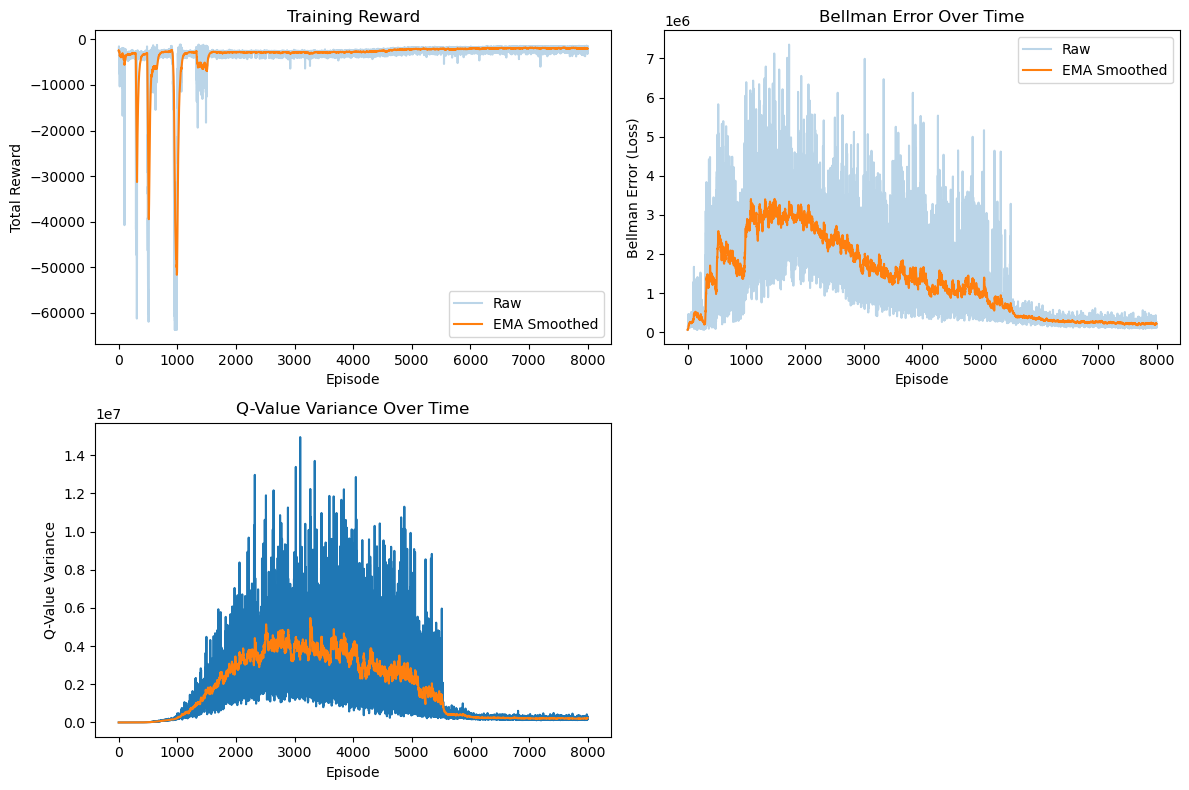

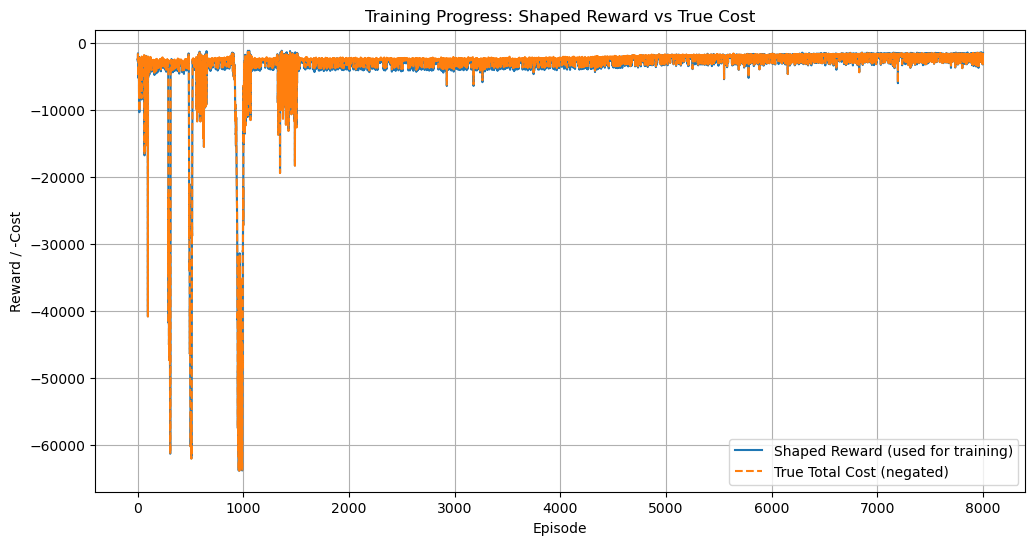

In [1]:
# This notebook demonstrates the training of the DQN model described in Section 3.
# It aligns with the environment design, reward shaping, and architecture used in the published study.
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

# Define the RL Environment for Construction Logistics
class ConstructionLogisticsEnv(gym.Env):
    def __init__(self):
        super(ConstructionLogisticsEnv, self).__init__()

        self.truck_capacity = 10                   # Each truck can deliver 10 tons
        self.valid_order_quantities = [0, 10, 20, 30, 40]  # Only full truckloads allowed
        self.max_inventory = 60                    # Site can store 60 tons max
        self.max_order = max(self.valid_order_quantities)  # Maximum possible per day
        
        self.storage_cost = 2                     # £2/ton/day (premium urban cost)
        self.shortage_cost = 100                  # £100/ton for delay-related downtime
        self.transport_cost = 100                 # £100/truck (fixed per truck, not per ton)
        
        self.time_horizon = 11
        self.current_time = 0
        self.inventory_level = 0
        self.lead_time = []
        self.pending_orders = deque()
        self.backlog = 0
        self.debug = False
        self.recent_truck_usage = [0, 0]  # usage on t-1 and t-2
        
        # Observation space adjusted for batching logic and max capacity
        # State = [inventory, day, backlog, expected_demand_today, lead_time, expected_demand_tomorrow, trucks used on day t-1 and t-2]
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0, 1, 0, 0, 0], dtype=np.float32),
            high=np.array([
                self.max_inventory,       # inventory
                self.time_horizon,        # current time
                2 * self.max_inventory,   # backlog
                20,                       # expected demand
                2,                        # lead time
                20,                       # next day demand
                4,                        # trucks used on day t-1
                4                        # trucks used on day t-2
            ], dtype=np.float32),
            dtype=np.float32
        )

        # Updated action space to reflect only batch sizes
        self.action_space = gym.spaces.Discrete(len(self.valid_order_quantities))
      

    def step(self, action):
        # Receive arriving orders
        while self.pending_orders and self.pending_orders[0][1] == self.current_time:
            delivery_qty = self.pending_orders.popleft()[0]
            available_space = self.max_inventory - self.inventory_level
            actual_delivery = min(delivery_qty, available_space)
            self.inventory_level += actual_delivery#
            if self.debug:
                print("Day: " ,self.current_time," Today's starting inventory: ", self.inventory_level)
            
        # Generate random demand influences (one sample each per day)
        self.weather_factor = np.random.choice([0.6, 0.85, 1.0], p=[0.02, 0.1, 0.88])
        self.crane_breakdown = np.random.choice([0.5, 1.0], p=[0.02, 0.98])
        self.worker_productivity = np.random.choice([0.8, 1.0], p=[0.05, 0.95])
        self.trnasport_latness = np.random.choice([0.8, 0.9, 1.0], p=[0.1, 0.8, 0.1])
        
        # Generate stochastic demand for the current day
        raw_demand = self.expected_demand[self.current_time]
        adjusted_demand = raw_demand * self.weather_factor \
                                       * self.crane_breakdown \
                                       * self.worker_productivity \
                                       * self.trnasport_latness
        
        if self.current_time == 0:
            demand = 0
        else:
            demand = int(adjusted_demand) + self.backlog
        if self.debug:    
            print("Day: " ,self.current_time," Today's Demand: ", demand)
        
        # Fulfill demand       
        shortage = max(0, demand - self.inventory_level)
        if self.debug:
            print("Day: " ,self.current_time," Today's Unmet: ", shortage)
        fulfilled = demand - shortage
        if self.debug:
            print("Day: " ,self.current_time," Today's fulfilled: ", fulfilled)
        self.inventory_level -= fulfilled
        if self.debug:
            print("Day: " ,self.current_time," Today's Final inventory level: ", self.inventory_level)
        self.backlog = shortage  # carry unmet demand to tomorrow
        if self.debug:
            print("Day: " ,self.current_time," backlog: ", self.backlog)
        
        # Place order if valid
        order_quantity = self.valid_order_quantities[action]
        num_trucks_today = order_quantity // self.truck_capacity
        self.recent_truck_usage.append(num_trucks_today)
        self.recent_truck_usage = self.recent_truck_usage[-2:]
        if order_quantity > 0:
            delivery_time = self.current_time + self.lead_time[self.current_time]
            if delivery_time < self.time_horizon:
                self.pending_orders.append((order_quantity, delivery_time))
                if self.debug:
                    print(f"Day: {self.current_time}, Order quantity: {order_quantity}, Delivery at: Day {delivery_time}")
    
        holding_cost = self.storage_cost * self.inventory_level
        if self.debug:
            print("Day:",self.current_time," holding cost: ", holding_cost)
        shortage_penalty = self.shortage_cost * shortage
        if self.debug:
            print("Day:",self.current_time," shortage_penalty: ", shortage_penalty)
        transport_cost = num_trucks_today * self.transport_cost
        if self.debug:
            print("Day:",self.current_time," transport_cost: ", transport_cost)
        
        # --- Base reward (negative cost) ---
        total_cost =  transport_cost + holding_cost + shortage_penalty 
        reward = -total_cost  # Default baseline reward
        if self.debug:
            print("Day:",self.current_time," Total cost today ", reward)
            print("====================================================")
            
         # --- Improved Reward Shaping (Just-in-Time Incentive) ---

        # --- JIT-Inspired Reward Shaping ---
        
        # 1. Bonus for exact match (ideal inventory = tomorrow's demand)
        if 0 < self.current_time < self.time_horizon - 1:
            ideal_inventory = self.expected_demand[self.current_time + 1]  # anticipate tomorrow
            diff = abs(self.inventory_level - ideal_inventory)
            reward += max(0, 20 - 2 * diff)  # bonus decreases as deviation grows
        
        # 2. Penalty for excessive stock (beyond what's needed for next 2 days)
        if self.current_time < self.time_horizon - 2:
            next_two_days_demand = self.expected_demand[self.current_time + 1] + self.expected_demand[self.current_time + 2]
            if self.inventory_level > next_two_days_demand + 5:
                penalty = (self.inventory_level - next_two_days_demand) * 1.5
                reward -= penalty
                if self.debug:
                    print(f"Overstock penalty: -{penalty:.1f}")
        
        # 3. End-of-horizon inventory penalty (already included, keep this)
        if self.current_time == self.time_horizon - 1:
            excess_penalty = self.inventory_level * 5
            reward -= excess_penalty
            if self.debug:
                print(f"End-of-episode penalty for leftover inventory: -{excess_penalty}")
        
        # 4. JIT Bonus for low inventory AND no shortage
        if shortage == 0 and self.inventory_level <= 2:
            reward += 30
        
        # 5. Deterrent for ordering when inventory is already near max
        if action > 0 and self.inventory_level > self.max_inventory * 0.8:
            reward -= 10
            
        next_day_demand = self.expected_demand[self.current_time + 1] if self.current_time + 1 < self.time_horizon else 0
        
        self.current_time += 1
        done = self.current_time >= self.time_horizon
    
        if done:     
            return np.zeros(self.observation_space.shape, dtype=np.float32), reward, done, {"cost": total_cost}
    
        state = np.array([
            self.inventory_level,                      # Current inventory
            self.current_time,                         # Current day
            self.backlog,                              # Unfulfilled demand
            self.expected_demand[self.current_time],   # Based on planned site activities
            self.lead_time[self.current_time],          # Current lead time
            next_day_demand,
            self.recent_truck_usage[0],
            self.recent_truck_usage[1]
        ], dtype=np.float32)
    
        return state, reward, done, {"cost": total_cost}


    def reset(self):
        self.current_time = 0
        self.inventory_level = 0
        self.backlog = 0        
        self.lead_time = np.random.choice([1, 2], size=self.time_horizon, p=[0.9, 0.1])
        self.pending_orders = deque()
        #self.expected_demand = np.full(self.time_horizon, 10)
        self.expected_demand = np.array([12, 14, 10, 8, 18, 20, 10, 10, 14, 10, 12])
        next_day_demand = self.expected_demand[1] if self.time_horizon > 1 else 0
        self.recent_truck_usage = [0, 0]  # Reset truck usage history
    
        state = np.array([
            self.inventory_level,
            self.current_time,
            self.backlog,
            self.expected_demand[self.current_time],
            self.lead_time[self.current_time],
            next_day_demand,
            self.recent_truck_usage[0],
            self.recent_truck_usage[1]
        ], dtype=np.float32)
        
        return state

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

env = ConstructionLogisticsEnv()
dqn = DQN(input_dim=8, output_dim=env.action_space.n)
target_dqn = DQN(input_dim=8, output_dim=env.action_space.n)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

epsilon = 1.0
epsilon_decay = 0.991 #0.991 #0.997
epsilon_min = 0.05 
num_episodes = 8000
batch_size = 64
memory = deque(maxlen=50000)
soft_tau = 0.05

ema_alpha = 0.05

def ema(values, alpha):
    ema_values = []
    for i, v in enumerate(values):
        if i == 0:
            ema_values.append(v)
        else:
            ema_values.append(alpha * v + (1 - alpha) * ema_values[-1])
    return ema_values

rewards_per_episode = []
losses_per_episode = []
q_variances = []

shaped_rewards_per_episode = []
true_costs_per_episode = []

def choose_action(state):
    # Get the current inventory level
    inventory_level = state[0]
    
    # Only allow actions that don't exceed max inventory
    possible_actions = [i for i, qty in enumerate(env.valid_order_quantities) if inventory_level + qty <= env.max_inventory]

    # If the inventory is full, only allow action 0 (no order)
    if inventory_level >= env.max_inventory:
        possible_actions = [0]
            
    # If epsilon-greedy, choose randomly from the valid actions
    if random.random() < epsilon:
        return random.choice(possible_actions)
    
    # Otherwise, choose the best action from the valid actions
    with torch.no_grad():
        q_values = dqn(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).squeeze(0)
        valid_q_values = [q_values[action] for action in possible_actions]
        best_action = possible_actions[torch.argmax(torch.tensor(valid_q_values)).item()]
        return best_action

for episode in range(num_episodes):

    if episode == num_episodes-1:
        env.debug = True  # Turn on detailed logging
    else:
        env.debug = False  # Turn off for all other episodes
    
    state = env.reset()
    total_reward = 0
    done = False
    total_cost = 0  # New: for real-world cost

    while not done:
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        real_cost = -reward if "cost" not in _ else _["cost"]
        
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        total_cost += real_cost
        
    rewards_per_episode.append(total_reward)
        
    shaped_rewards_per_episode.append(total_reward)
    true_costs_per_episode.append(total_cost)

    if len(memory) > batch_size:
        batch = random.sample(memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)

        q_values = dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = target_dqn(next_states).max(1)[0].detach()
        target_q_values = rewards + (0.99 * next_q_values * (~dones))
        loss = loss_fn(q_values, target_q_values)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Soft update
        for target_param, param in zip(target_dqn.parameters(), dqn.parameters()):
            target_param.data.copy_(soft_tau * param.data + (1.0 - soft_tau) * target_param.data)

        losses_per_episode.append(loss.item())
        q_variances.append(dqn(states).var().item())
   
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    if episode % 100 == 0:
        
        print(f"Episode {episode}, Total Reward: {total_reward}")
        
# Apply EMA smoothing
rewards_ema = ema(rewards_per_episode, ema_alpha)
loss_ema = ema(losses_per_episode, ema_alpha)
q_var_ema = ema(q_variances, ema_alpha)

# Plot Performance
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(rewards_per_episode, alpha=0.3, label='Raw')
plt.plot(rewards_ema, label='EMA Smoothed')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(losses_per_episode, alpha=0.3, label='Raw')
plt.plot(loss_ema, label='EMA Smoothed')
plt.xlabel('Episode')
plt.ylabel('Bellman Error (Loss)')
plt.title('Bellman Error Over Time')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(q_variances)
plt.plot(q_var_ema, label='Q-Variance EMA')
plt.xlabel('Episode')
plt.ylabel('Q-Value Variance')
plt.title('Q-Value Variance Over Time')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(shaped_rewards_per_episode, label="Shaped Reward (used for training)")
plt.plot([-c for c in true_costs_per_episode], label="True Total Cost (negated)", linestyle="--")
plt.xlabel("Episode")
plt.ylabel("Reward / -Cost")
plt.legend()
plt.title("Training Progress: Shaped Reward vs True Cost")
plt.grid(True)
plt.show()

#torch.save(dqn.state_dict(), "trained_dqn_model.pth")
